# M03. Predict Pulls
- Predict when pitcher gets removed from the game

In [1]:
%run "U1. Imports.ipynb"
%run "U2. Utilities.ipynb"
%run "U3. Classes.ipynb"
%run "D3. Simulation Functions.ipynb"

baseball_path = r'C:\Users\james\Documents\MLB\Database'

db_path = r'C:\Users\james\Documents\MLB\Database\MLBDB.db'
engine = create_engine(f'sqlite:///{db_path}')

here
Done
Code was last run on: 2023-11-06


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import log_loss, classification_report, f1_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from tensorflow import keras
from sklearn.impute import SimpleImputer

import joblib
import matplotlib.pyplot as plt

In [3]:
print(pitcher_stats_fg, pitcher_stats_fg2)

['H9', 'HR9', 'K9', 'BB9', 'GBrate', 'FBrate', 'LDrate', 'SIERA'] ['H9', 'HR9', 'K9', 'BB9', 'GBrate', 'FBrate', 'LDrate', 'SIERA', 'reliability', 'IP_start']


In [4]:
%run "A03. Steamer.ipynb"

### Dataset

In [5]:
# Choose the last instance of each player in each game, assuming they have enough PAs
sql_query = f'''
    SELECT *
    FROM "Dataset"
'''

complete_dataset = pd.read_sql_query(sql_query, con=engine)

In [6]:
complete_dataset.head()

,date,gamePk,atBatIndex,batterName,pitcherName,batter,pitcher,batSide,pitchHand,eventsModel,pa_b,ab_b,pa_p,ab_p,b1_b,b2_b,b3_b,hr_b,bb_b,hbp_b,so_b,fo_b,go_b,lo_b,po_b,estimated_woba_using_speedangle_b,to_left_b,to_middle_b,to_right_b,hard_hit_b,barrel_b,iso_b,slg_b,obp_b,woba_b,totalDistance_b,launchSpeed_b,b1_b_long,b2_b_long,b3_b_long,hr_b_long,bb_b_long,hbp_b_long,so_b_long,fo_b_long,go_b_long,lo_b_long,po_b_long,estimated_woba_using_speedangle_b_long,to_left_b_long,to_middle_b_long,to_right_b_long,hard_hit_b_long,barrel_b_long,iso_b_long,slg_b_long,obp_b_long,woba_b_long,totalDistance_b_long,launchSpeed_b_long,b1_p,b2_p,b3_p,hr_p,bb_p,hbp_p,so_p,fo_p,go_p,lo_p,po_p,estimated_woba_using_speedangle_p,to_left_p,to_middle_p,to_right_p,hard_hit_p,barrel_p,iso_p,slg_p,obp_p,woba_p,maxSpeed_p,maxSpin_p,b1_p_long,b2_p_long,b3_p_long,hr_p_long,bb_p_long,hbp_p_long,so_p_long,fo_p_long,go_p_long,lo_p_long,po_p_long,estimated_woba_using_speedangle_p_long,to_left_p_long,to_middle_p_long,to_right_p_long,hard_hit_p_long,barrel_p_long,iso_p_long,slg_p_long,obp_p_long,woba_p_long,maxSpeed_p_long,maxSpin_p_long,venue_1,venue_2,venue_3,venue_4,venue_5,venue_7,venue_10,venue_12,venue_13,venue_14,venue_15,venue_16,venue_17,venue_19,venue_22,venue_31,venue_32,venue_680,venue_2392,venue_2394,venue_2395,venue_2535,venue_2536,venue_2602,venue_2680,venue_2681,venue_2701,venue_2735,venue_2756,venue_2889,venue_3289,venue_3309,venue_3312,venue_3313,venue_4169,venue_4705,venue_5010,venue_5325,venue_5365,venue_5381,venue_5445,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,p_L,b_L,x_vect,y_vect,temperature,onFirst,onSecond,onThird,inning,top,score_diff,imp_b,imp_p,halfInning,awayScore,homeScore,rbi,b1,b2,b3,hr,bb,hbp,so,fo,go,lo,po
0,20150329,429555,0,Josh Harrison,Shelby Miller,543281,571946,R,R,go,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,67,0,0,0,1,1,0.0,0,0,top,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1,0,0
1,20150329,429555,1,Jaff Decker,Shelby Miller,543094,571946,L,R,go,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.0,0.0,67,0,0,0,1,1,0.0,0,0,top,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1,0,0
2,20150329,429555,2,Starling Marte,Shelby Miller,516782,571946,R,R,so,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,67,0,0,0,1,1,0.0,0,1,top,0,0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,0,0,0,0
3,20150329,429555,3,Eric Young Jr.,Stolmy Pimentel,458913,516935,L,R,go,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

### Steamer

In [7]:
# Choose the last instance of each player in each game, assuming they have enough PAs
sql_query = f'''
  SELECT *
  FROM "Steamer Pitchers"
'''

steamer_pitchers_df = pd.read_sql_query(sql_query, con=engine)

In [8]:
# Clean
steamer_pitchers_df2 = clean_steamer_pitchers(steamer_pitchers_df)
steamer_pitchers_df2.dropna(subset=pitcher_stats_fg2, inplace=True)

In [9]:
steamer_pitchers_df2.head()

,date,firstname,lastname,mlbamid,steamerid,H9,HR9,K9,BB9,GBrate,FBrate,LDrate,SIERA,reliability,IP_start
0,20140617,Craig,Kimbrel,518886.0,6655,5.589724,0.4786,13.6858,2.7747,0.455,0.335,0.210571,1.92,0.58064,0.0
1,20140617,Aroldis,Chapman,547973.0,10233,5.004519,0.6532,15.0427,3.4555,0.410,0.388,0.202224,1.85,0.55961,0.0
2,20140617,Koji,Uehara,493157.0,9227,6.925841,0.9029,10.8841,1.5271,0.355,0.433,0.212860,2.34,0.55498,0.0
3,20140617,Kenley,Jansen,445276.0,3096,6.112634,0.7299,12.4814,2.7269,0.391,0.409,0.199716,2.27,0.59125,0.0
4,20140617,Greg,Holland,518813.0,7196,6.376248,0.5989,11.9605,2.8349,0.437,0.358,0.205506,2.41,0.58857,0.0


### Merge

In [10]:
# Find the dates of Steamer projections
# We'll take the most recent and merge in that projection for each player
pitcher_steamer_dates = list(steamer_pitchers_df2['date'].unique())

# Define a function to find the largest number in "steamer_dates" less than or equal to a given "date"
def find_steamer_date(date, steamer_dates):
    max_steamer_date = max(filter(lambda d: d <= date, steamer_dates), default=None)
    return max_steamer_date

# Apply the function to create the "steamer_date" column in your DataFrame
complete_dataset["pitcher_date"] = complete_dataset["date"].apply(lambda x: find_steamer_date(x, pitcher_steamer_dates))

In [11]:
# Merge
complete_merged_df = pd.merge(complete_dataset, steamer_pitchers_df2[['mlbamid', 'date'] + pitcher_stats_fg2] , left_on=['pitcher', 'pitcher_date'], right_on=['mlbamid', 'date'], how='left', suffixes=("", "_fg"))
complete_merged_df.drop_duplicates(subset=['date', 'gamePk', 'atBatIndex'], keep='last', inplace=True)
complete_merged_df.head()

,date,gamePk,atBatIndex,batterName,pitcherName,batter,pitcher,batSide,pitchHand,eventsModel,pa_b,ab_b,pa_p,ab_p,b1_b,b2_b,b3_b,hr_b,bb_b,hbp_b,so_b,fo_b,go_b,lo_b,po_b,estimated_woba_using_speedangle_b,to_left_b,to_middle_b,to_right_b,hard_hit_b,barrel_b,iso_b,slg_b,obp_b,woba_b,totalDistance_b,launchSpeed_b,b1_b_long,b2_b_long,b3_b_long,hr_b_long,bb_b_long,hbp_b_long,so_b_long,fo_b_long,go_b_long,lo_b_long,po_b_long,estimated_woba_using_speedangle_b_long,to_left_b_long,to_middle_b_long,to_right_b_long,hard_hit_b_long,barrel_b_long,iso_b_long,slg_b_long,obp_b_long,woba_b_long,totalDistance_b_long,launchSpeed_b_long,b1_p,b2_p,b3_p,hr_p,bb_p,hbp_p,so_p,fo_p,go_p,lo_p,po_p,estimated_woba_using_speedangle_p,to_left_p,to_middle_p,to_right_p,hard_hit_p,barrel_p,iso_p,slg_p,obp_p,woba_p,maxSpeed_p,maxSpin_p,b1_p_long,b2_p_long,b3_p_long,hr_p_long,bb_p_long,hbp_p_long,so_p_long,fo_p_long,go_p_long,lo_p_long,po_p_long,estimated_woba_using_speedangle_p_long,to_left_p_long,to_middle_p_long,to_right_p_long,hard_hit_p_long,barrel_p_long,iso_p_long,slg_p_long,obp_p_long,woba_p_long,maxSpeed_p_long,maxSpin_p_long,venue_1,venue_2,venue_3,venue_4,venue_5,venue_7,venue_10,venue_12,venue_13,venue_14,venue_15,venue_16,venue_17,venue_19,venue_22,venue_31,venue_32,venue_680,venue_2392,venue_2394,venue_2395,venue_2535,venue_2536,venue_2602,venue_2680,venue_2681,venue_2701,venue_2735,venue_2756,venue_2889,venue_3289,venue_3309,venue_3312,venue_3313,venue_4169,venue_4705,venue_5010,venue_5325,venue_5365,venue_5381,venue_5445,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,p_L,b_L,x_vect,y_vect,temperature,onFirst,onSecond,onThird,inning,top,score_diff,imp_b,imp_p,halfInning,awayScore,homeScore,rbi,b1,b2,b3,hr,bb,hbp,so,fo,go,lo,po,pitcher_date,mlbamid,date_fg,H9,HR9,K9,BB9,GBrate,FBrate,LDrate,SIERA,reliability,IP_start
1,20150329,429555,0,Josh Harrison,Shelby Miller,543281,571946,R,R,go,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,67,0,0,0,1,1,0.0,0,0,top,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1,0,0,20140928,571946.0,20140928.0,8.7138,1.0854,7.6003,3.4952,0.395,0.398,0.206699,4.30,0.81373,7.407407
3,20150329,429555,1,Jaff Decker,Shelby Miller,543094,571946,L,R,go,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0.0,0.0,67,0,0,0,1,1,0.0,0,0,top,0,0,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1,0,0,20140928,571946.0,20140928.0,8.7138,1.0854,7.6003,3.4952,0.395,0.398,0.206699,4.30,0.81373,7.407407
5,20150329,429555,2,Starling Marte,Shelby Miller,516782,571946,R,R,so,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0.0,67,0,0,0,1,1,0.0,0,1,top,0,0,0,0.0,0.0,0.0,0.0,0.0,0,1.0,0,0,0,0,20140928,571946.0,20140928.0,8.7138,1.0854

In [12]:
def pull_dataset(df): 
    # Calculate scores bot batter and pitcher teams
    df['pitcher_score'] = np.where(df['halfInning'] == "top", df['homeScore'], df['awayScore'])
    df['batter_score'] = np.where(df['halfInning'] == "top", df['awayScore'], df['homeScore'])
    
    # Number of batters faced (will be used to calculate rolling sum)
    df['faced'] = 1
    
    # Convert to numeric
    df['rbi'] = df['rbi'].astype('int')
    
    # Determine year
    df['year'] = df['date'].astype('str').str[:4]
    
    # Cumulative counts
    # Stats to sum
    sums_list = ['gamePk', 'pitcher'] + events_list + ['rbi', 'faced']
    # Calculate
    sums = df[sums_list].groupby(['gamePk', 'pitcher']).cumsum()
    # Add suffix
    sums = sums.add_suffix("_sum")
    
    # Add rolling sums
    df = pd.concat([df, sums], axis=1)
    
    # Identify if it's the bottom of the inning (a little more helpful than "top" as it's sortable)
    df['bottom'] = (df['top'] == 0).astype('int')
    
    # Sort to identify starting pitchers
    df = df.sort_values(by=['date', 'gamePk', 'bottom', 'atBatIndex'])
    
    # The starter has the lowest atBatIndex
    df['atBatIndex_min'] = df.groupby(['gamePk', 'bottom'])['atBatIndex'].transform('min')
    df['start'] = (df['atBatIndex'] == df['atBatIndex_min']).astype('int')
        
    # Identify starter throughout
    df['starter'] = df.groupby(['pitcher', 'gamePk'])['start'].cumsum()
    
    # Keep only starters
    df = df.query('starter == 1')
    
    # The starter is pulled at their highest atBatIndex
    df['atBatIndex_max'] = df.groupby(['gamePk', 'bottom'])['atBatIndex'].transform('max')
    df['pulled'] = (df['atBatIndex'] == df['atBatIndex_max']).astype('int')
    
    # Rolling sums stats (post-rolling sum)
    rolled_sums_list = [f'{stat}_sum' for stat in events_list] + ['rbi_sum', 'faced_sum']
    # Variables to keep
    keep_list = ['date', 'year', 'gamePk', 'pitcher', 'pitcherName', 'batter', 'batterName', 'atBatIndex', 'pitcher_score', 'batter_score'] + pull_inputs + pitcher_stats_fg2 + rolled_sums_list + ['start', 'pulled']
    
    # Keep relevant variables
    df = df[keep_list]
    
    # Drop if we don't have Steamer
    df.dropna(subset=pitcher_stats_fg2, inplace=True)
    
    
    return df

In [13]:
pulls_dataset = pull_dataset(complete_merged_df)

In [14]:
# Pitchers
with open(os.path.join(model_path, "pitcher_stats_fg_scaler_20231027.pkl"), "rb") as file:
    pitcher_stats_fg_scaler = pickle.load(file)

In [15]:
pulls_dataset[pitcher_stats_fg] = pitcher_stats_fg_scaler.fit_transform(pulls_dataset[pitcher_stats_fg])

In [16]:
# Full dataset
X = pulls_dataset[pull_inputs3]
y = pulls_dataset['pulled']

# Split into training and testing groups
X_train = pulls_dataset.groupby(pulls_dataset['year']).apply(lambda x: x.head(int(len(x)*2/3)))
X_test = pulls_dataset.groupby(pulls_dataset['year']).apply(lambda x: x.tail(int(len(x)*1/3)))

### Train Models

##### Dataset

### Pulls

In [17]:
%%time
pulls_filename = "model_pulls_" + "voting_" + f"{todaysdate}.sav"

# Define the individual models in the ensemble
models = [
    LogisticRegression(solver='lbfgs', max_iter=20),  
    LogisticRegression(solver='saga', max_iter=20),   
    # MLPClassifier(hidden_layer_sizes=(100,100), activation='relu', random_state=1, max_iter=100),  
    ]


# Create the ensemble classifier using VotingClassifier
model_pulls = VotingClassifier(estimators=[('model'+str(i+1), model) for i, model in enumerate(models)], voting='soft', n_jobs=-2).fit(X_train[pull_inputs3], X_train[['pulled']].values.ravel())

# Save model
pickle.dump(model_pulls, open(os.path.join(model_path, pulls_filename), 'wb'))

CPU times: total: 281 ms
Wall time: 9.57 s


In [18]:
# Make predictions
proba = model_pulls.predict_proba(X_test[pull_inputs3])
X_test['is_kept_pred'] = proba[:, 0]  # Assign the first column of probabilities
X_test['is_pulled_pred'] = proba[:, 1]  # Assign the second column of probabilities

In [19]:
# Add xtiles (to examine how well predictions match actual results)
X_test['decile'] = pd.qcut(X_test['is_pulled_pred'], 10, labels=False)

df_name = "is_pulled" + "_df"
globals()[df_name] = X_test.groupby('decile').mean().reset_index()

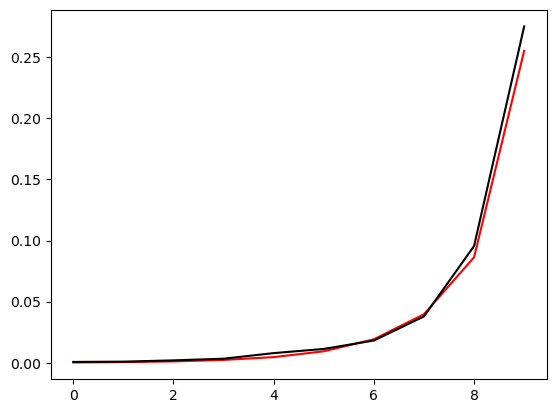

In [20]:
# Create figures
plt.plot(is_pulled_df['decile'], is_pulled_df['is_pulled_pred'], color='red')
plt.plot(is_pulled_df['decile'], is_pulled_df['pulled'], color='black')
plt.show() 

In [23]:

input_data = np.array([[7, 1, 0, 1, 3, 1, 6, 3, 1, 2, 3, 5.7071541218638]])


proba = model_pulls.predict_proba(input_data)
proba

array([[9.99169068e-01, 8.30932446e-04]])